# Prep

In [1]:
# for data handling & exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for EDA
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import pointbiserialr

# for preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 

# for modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# for reviewing algorithms
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, roc_auc_score, log_loss, mean_squared_error, plot_confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from mlxtend.evaluate import bias_variance_decomp
from scipy.sparse.linalg import svds
import shap

# for hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      98000 non-null  int64  
 1   f_00    98000 non-null  float64
 2   f_01    98000 non-null  float64
 3   f_02    98000 non-null  float64
 4   f_03    98000 non-null  float64
 5   f_04    98000 non-null  float64
 6   f_05    98000 non-null  float64
 7   f_06    98000 non-null  float64
 8   f_07    98000 non-null  int64  
 9   f_08    98000 non-null  int64  
 10  f_09    98000 non-null  int64  
 11  f_10    98000 non-null  int64  
 12  f_11    98000 non-null  int64  
 13  f_12    98000 non-null  int64  
 14  f_13    98000 non-null  int64  
 15  f_14    98000 non-null  float64
 16  f_15    98000 non-null  float64
 17  f_16    98000 non-null  float64
 18  f_17    98000 non-null  float64
 19  f_18    98000 non-null  float64
 20  f_19    98000 non-null  float64
 21  f_20    98000 non-null  float64
 22

In [3]:
df.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [4]:
df_sample = pd.read_csv('sample_submission.csv')
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Id         98000 non-null  int64
 1   Predicted  98000 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB


# Learn the Data / EDA

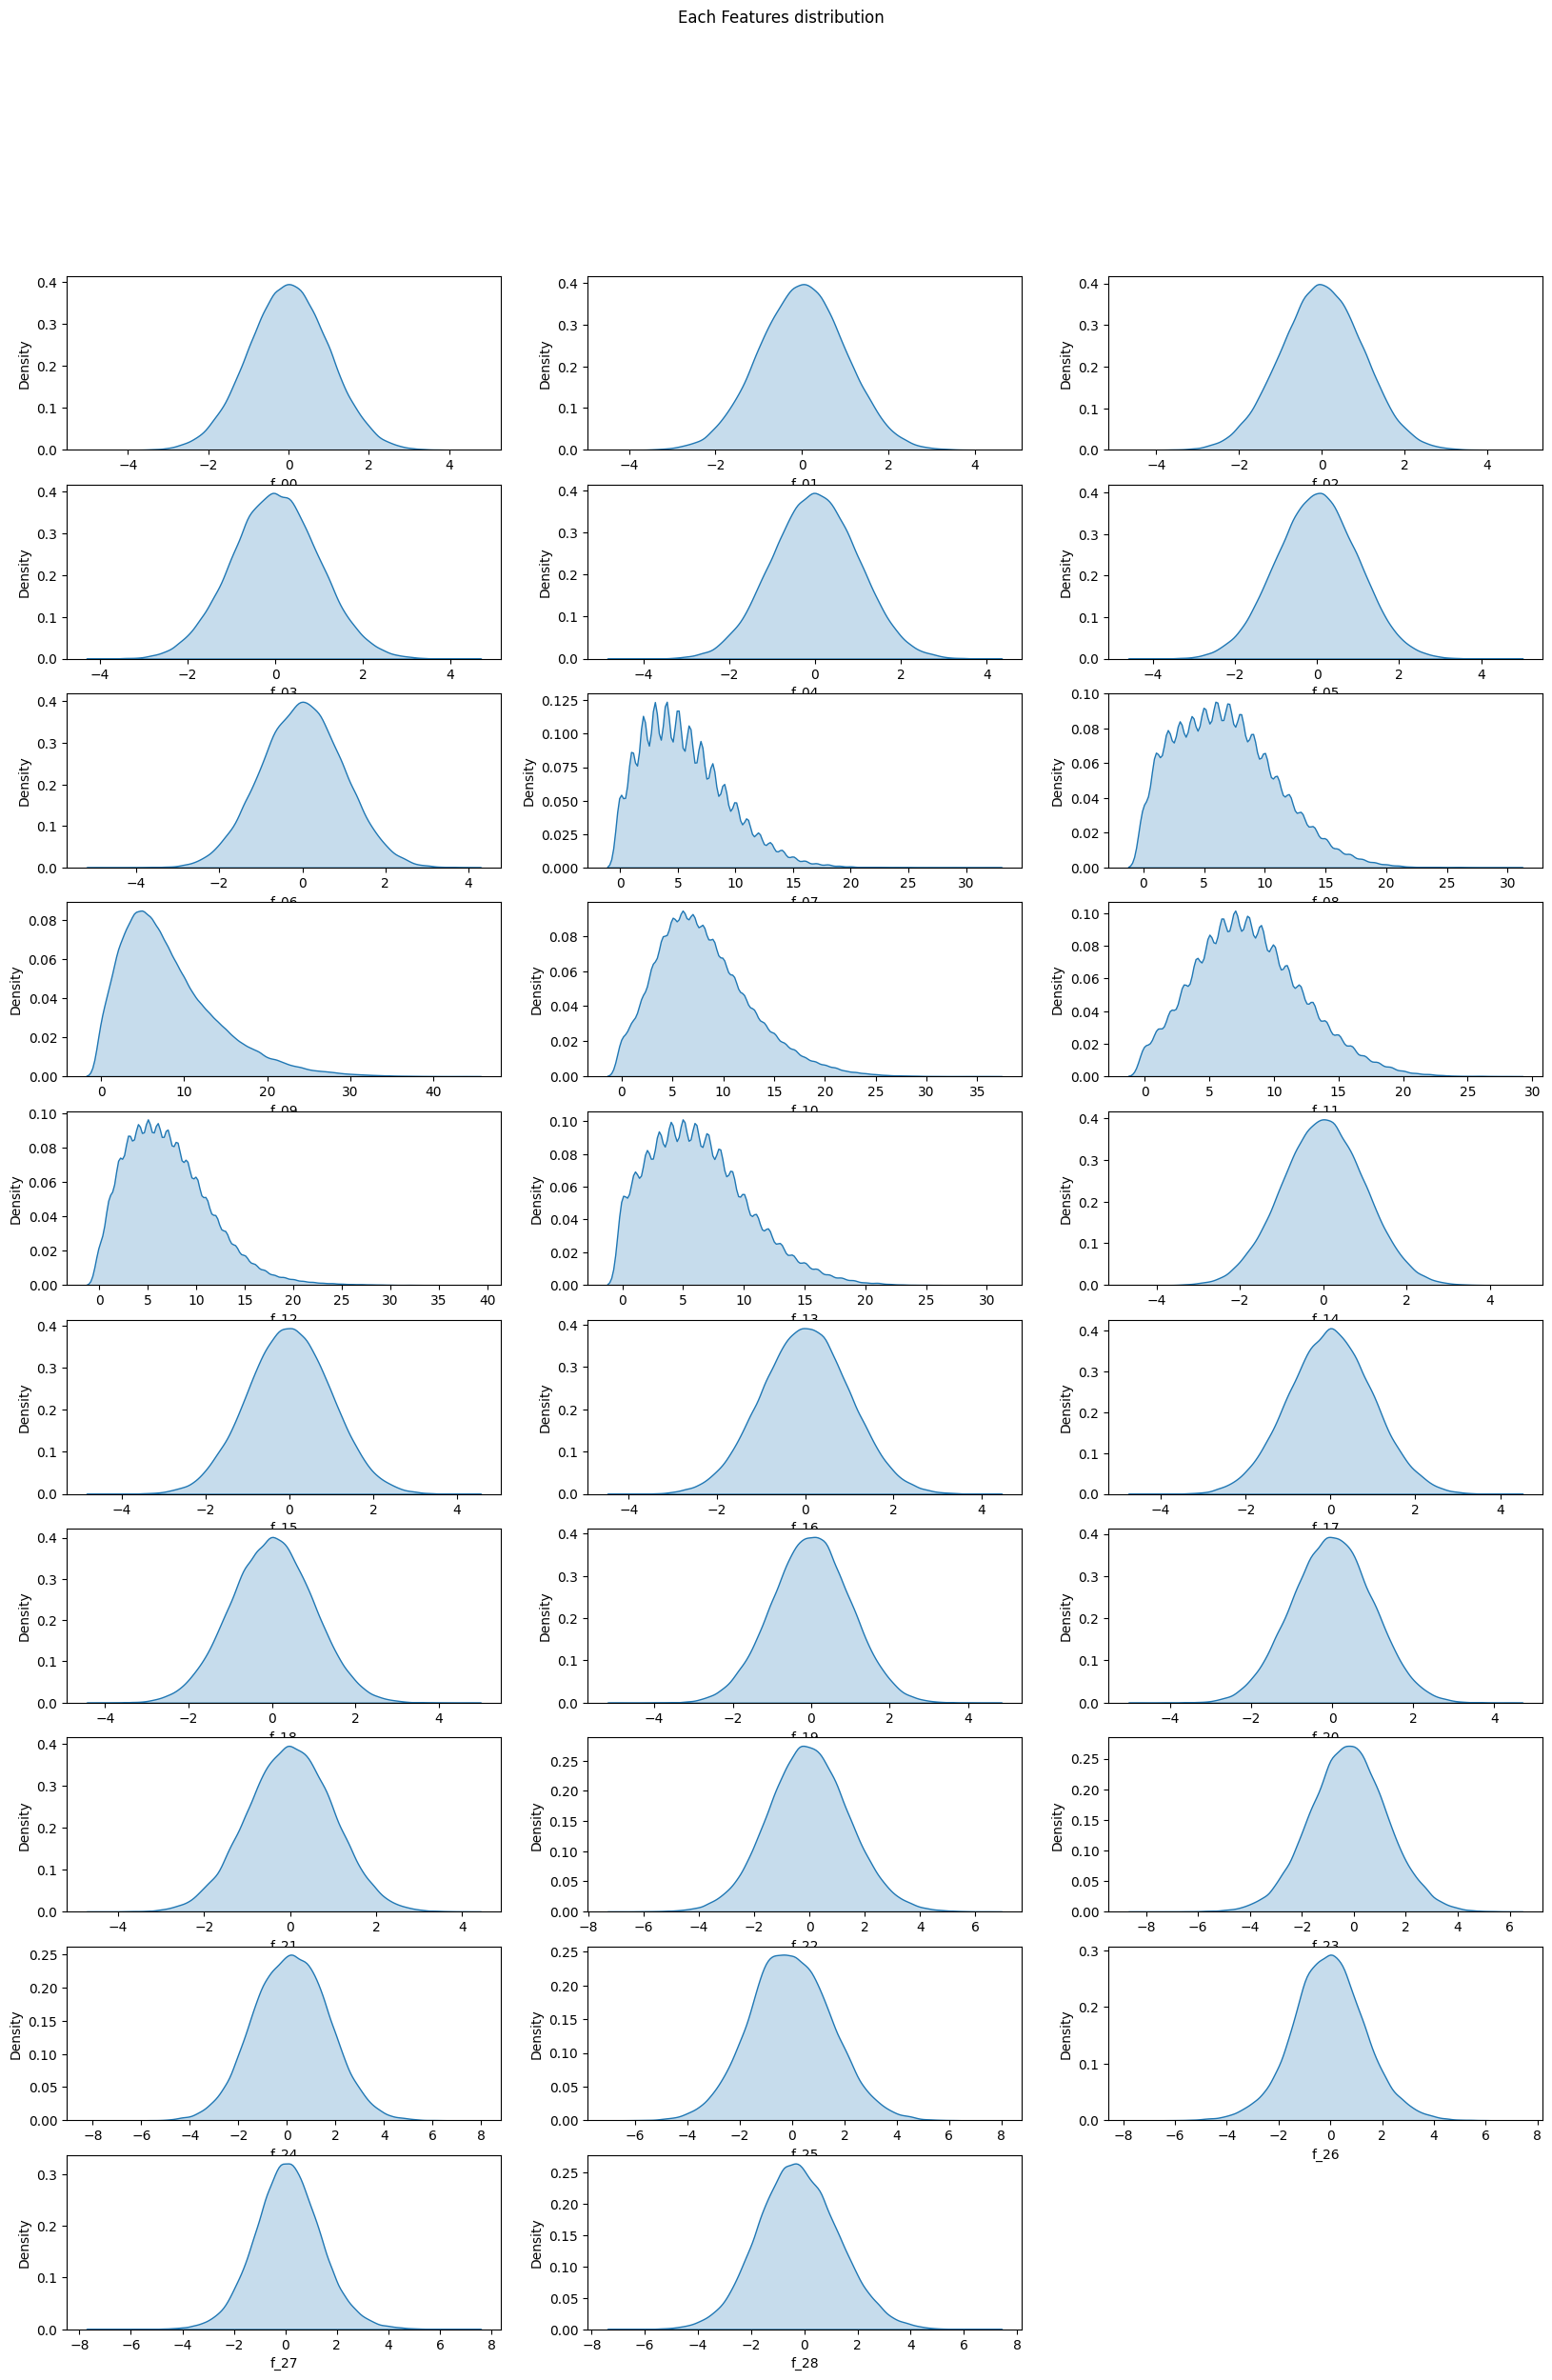

In [5]:
# check normality
cols = list(df.columns[1:])

plt.figure(figsize=(20,28))
for index,col in enumerate(cols):
    plt.subplot(10,3,index+1)
    sns.kdeplot(x = df[col],shade='fill',palette='bright')
plt.suptitle("Each Features distribution")
plt.show()

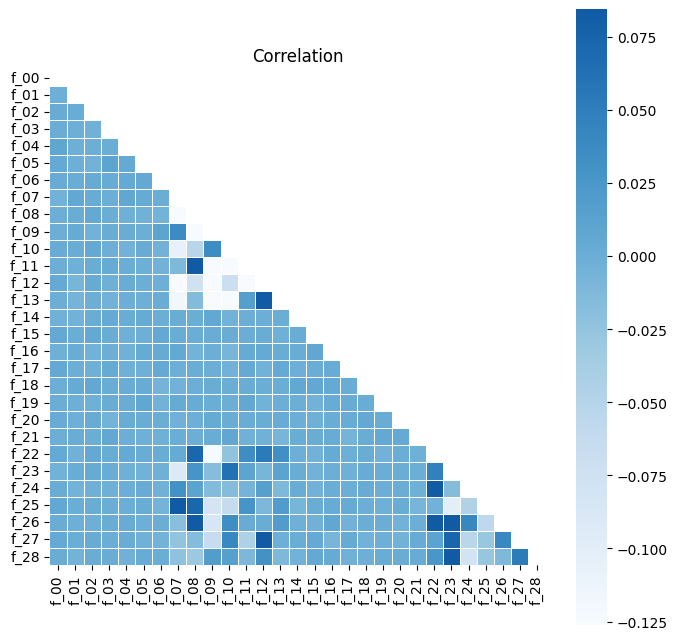

In [6]:
# check correlation

plt.figure(figsize=(8, 8))

corr = df.iloc[:, 1:].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, robust=True, center=0, square=True, linewidths=.6, cmap='Blues')
plt.title('Correlation')
plt.show()

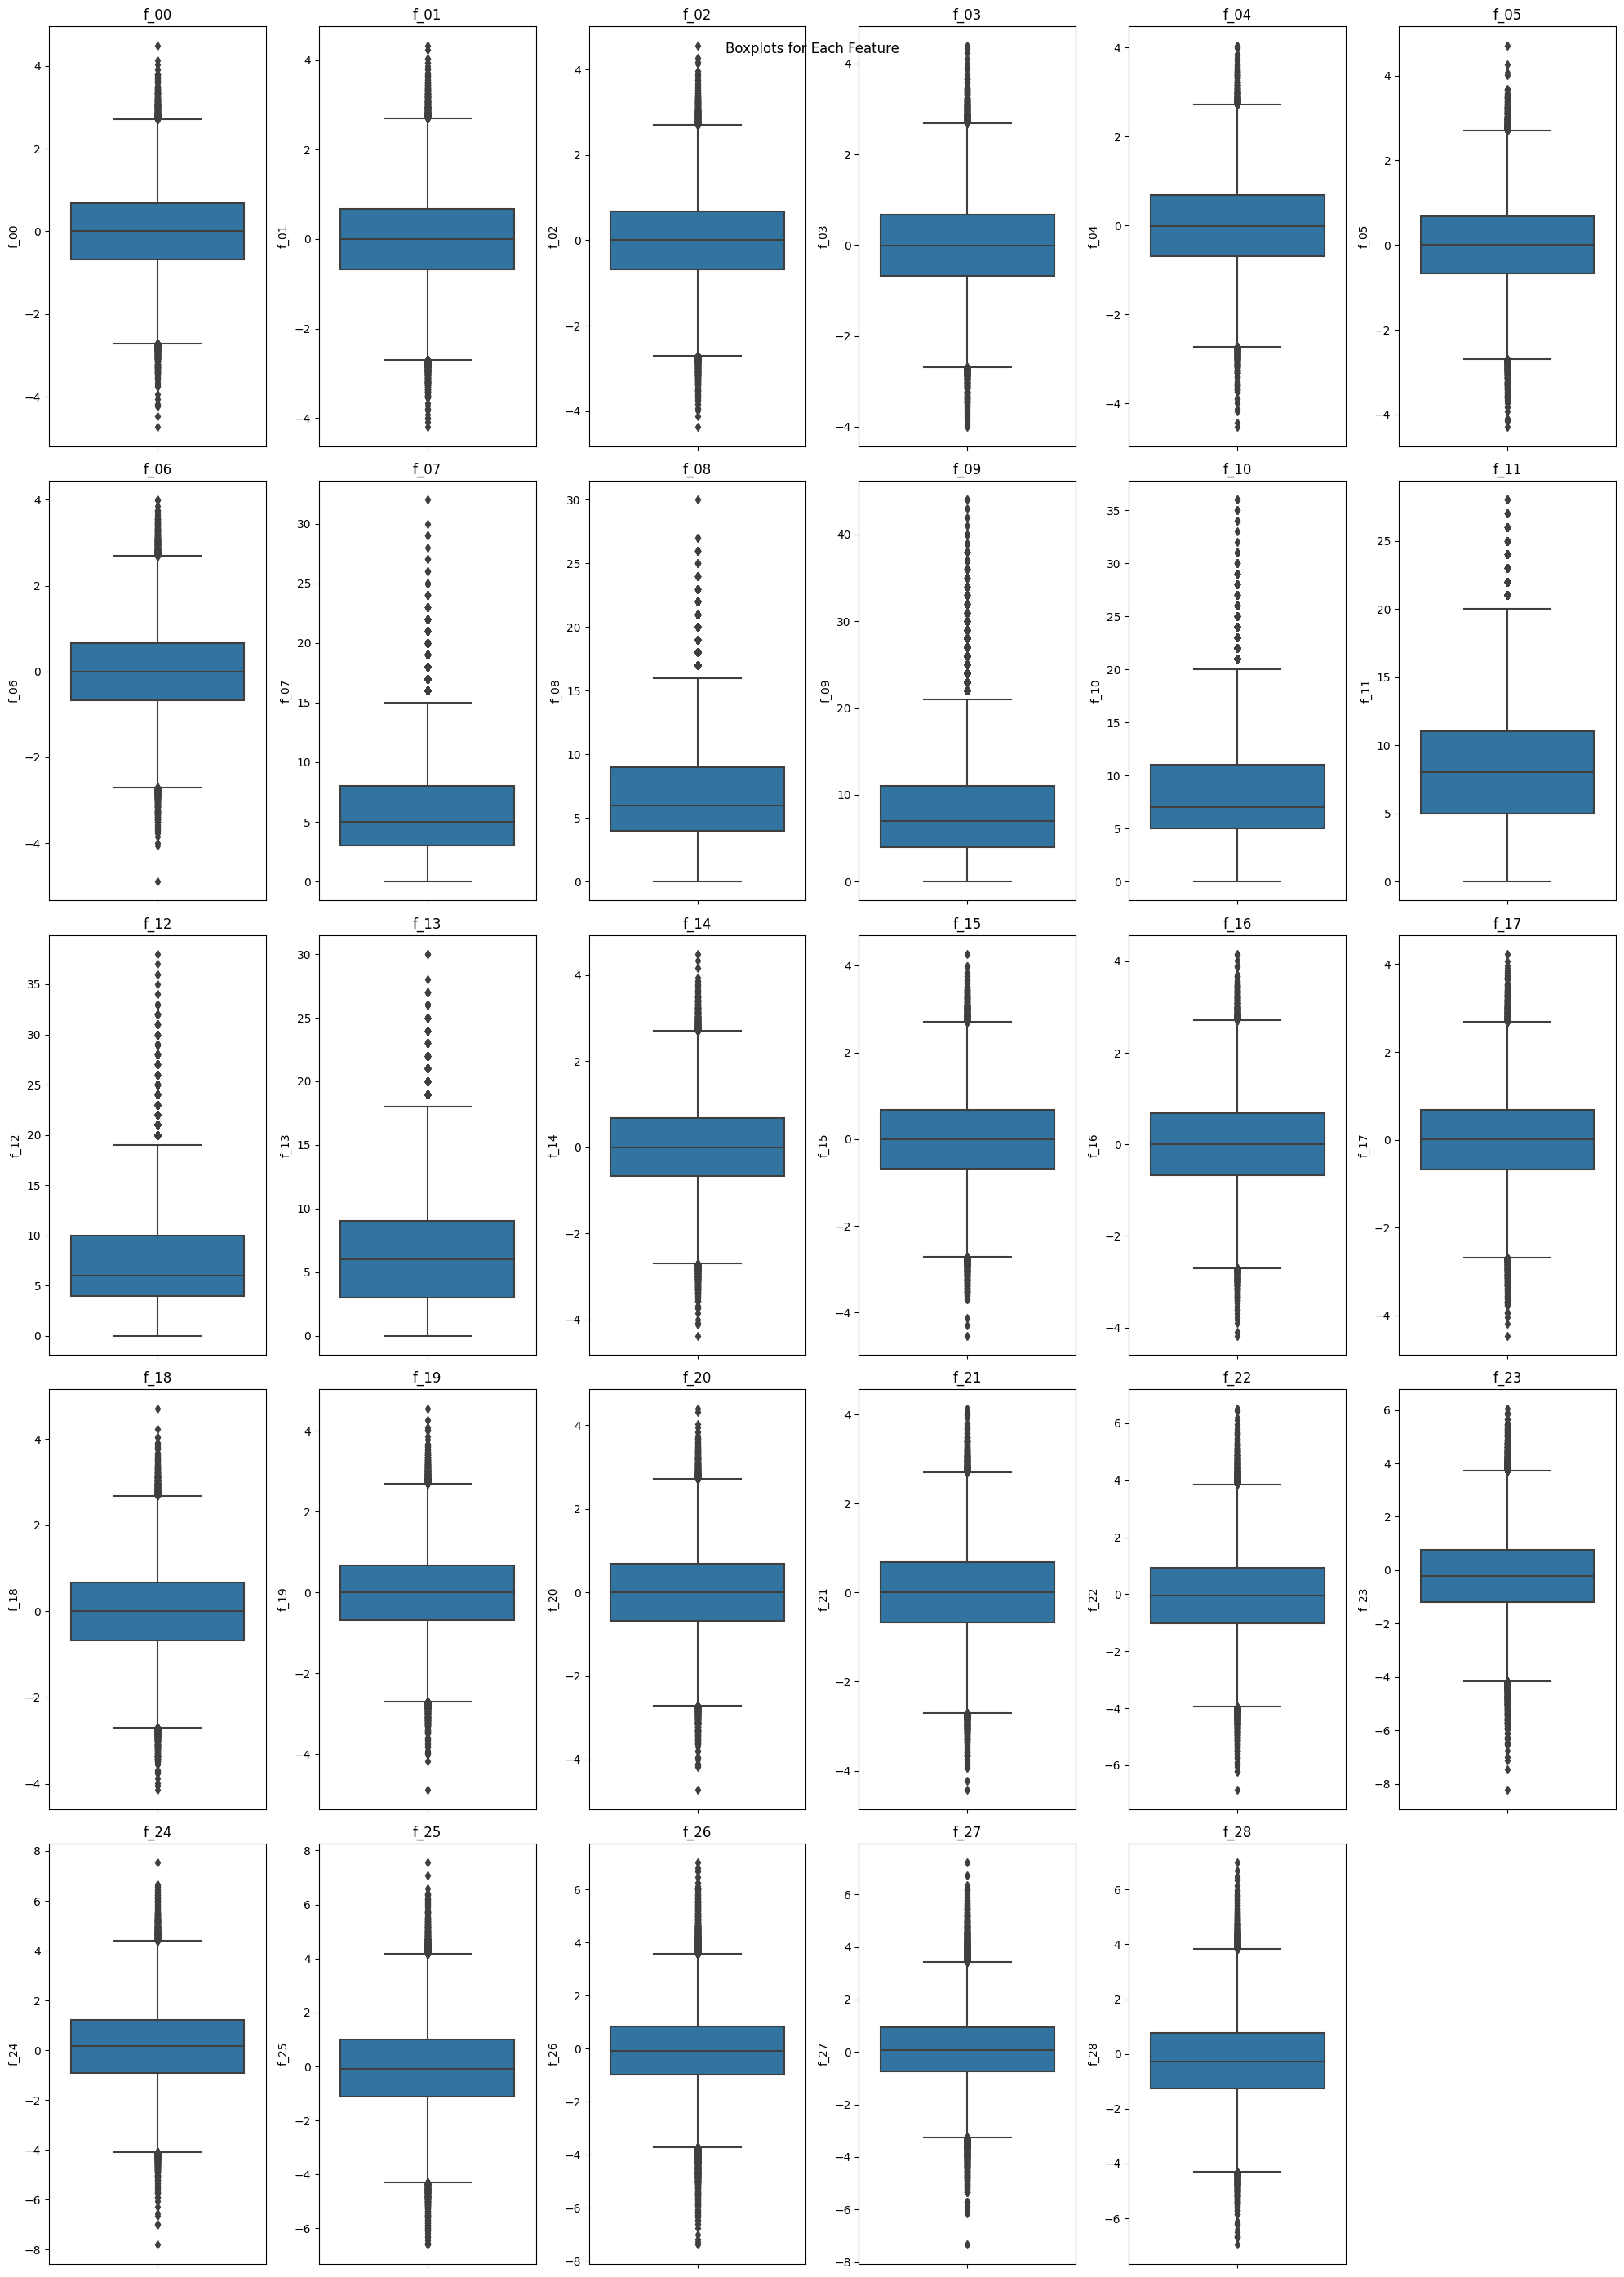

In [8]:
plt.figure(figsize=(20, 28))
for index,col in enumerate(cols):
    plt.subplot(5, 6, index + 1)
    sns.boxplot(y=df[f'f_{str(index).zfill(2)}'])
    plt.title(col)
    plt.tight_layout()
plt.suptitle("Boxplots for Each Feature")
plt.show()

## Preprocessing

In [9]:
# remove outlier
for feature in df.columns[1:]:
    lower_threshold = df[feature].quantile(0.01)  
    upper_threshold = df[feature].quantile(0.99)
    df[feature] = np.where(df[feature] < lower_threshold, lower_threshold, 
                             np.where(df[feature] > upper_threshold, upper_threshold, df[feature]))

In [10]:
# let's normalize the data using power transformer
from sklearn.preprocessing import PowerTransformer

data_without_id = df.drop(columns=['id'])

transformer = PowerTransformer()
scaled = df.copy()
scaled.iloc[:, 1:] = transformer.fit_transform(data_without_id)

In [11]:
scaled.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.396621,-0.934958,0.659865,0.601335,-0.840671,0.747810,2.299038,-0.984082,1.399140,...,-0.482018,-0.767853,-0.777548,-0.723032,0.930426,-0.692690,0.784451,0.985630,1.072329,0.708157
1,1,-0.700954,-0.467435,0.665205,1.013384,-1.676080,0.880399,-0.087146,-0.984082,-0.880695,...,-0.431820,-0.089678,-1.809416,-0.546852,0.463861,1.053077,-0.120099,-0.565098,0.377658,-1.670540
2,2,0.820381,0.325252,-1.188022,-0.633788,0.110624,0.799061,2.025345,0.017205,1.026761,...,-0.416384,-1.628507,1.217548,2.247338,0.089483,-1.549612,-0.580544,1.004617,-0.952474,-2.343862
3,3,-0.509804,0.228040,0.266919,0.238176,0.425155,-1.240431,0.146950,0.285086,-1.216800,...,0.631545,1.307256,0.542673,0.747302,-1.245097,0.843710,-1.198273,-0.404832,-0.102916,0.333107
4,4,-0.682703,-1.064130,-0.276616,-1.866357,-0.291281,-1.881859,0.801403,0.763219,0.185755,...,-1.643259,-0.440315,0.327549,0.233690,-1.516003,0.865673,-0.626771,1.194351,-0.384859,-1.184133


In [12]:
# PCA Analysis feature engineering
from sklearn.decomposition import PCA
pca = PCA(n_components=min(*scaled.iloc[:, 1:].shape))
principal_components = pca.fit_transform(scaled.iloc[:, 1:])

In [13]:
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from sklearn.metrics import silhouette_score

# How many cluster should we use?

## Gausssian Mixture

In [20]:
cluster_range = range(3, 13)

sil_scores = []
aic_scores = []
bic_scores = []

all_principal_components = pca.transform(scaled.iloc[:, 1:])

for n_clusters in cluster_range:
    gm = GaussianMixture(n_components=n_clusters, random_state=42)
    gm_preds = gm.fit_predict(all_principal_components)
    
    sil = silhouette_score(all_principal_components, gm_preds)
    sil_scores.append(sil)
    
    aic = gm.aic(all_principal_components)
    bic = gm.bic(all_principal_components)
    aic_scores.append(aic)
    bic_scores.append(bic)

max_aic, min_aic = max(aic_scores), min(aic_scores)
max_bic, min_bic = max(bic_scores), min(bic_scores)
max_sil, min_sil = max(sil_scores), min(sil_scores)

aic_scores = [(x-min_aic)/(max_aic-min_aic) for x in aic_scores]
bic_scores = [(x-min_bic)/(max_bic-min_bic) for x in bic_scores]
sil_scores = [(x-min_sil)/(max_sil-min_sil) for x in sil_scores]

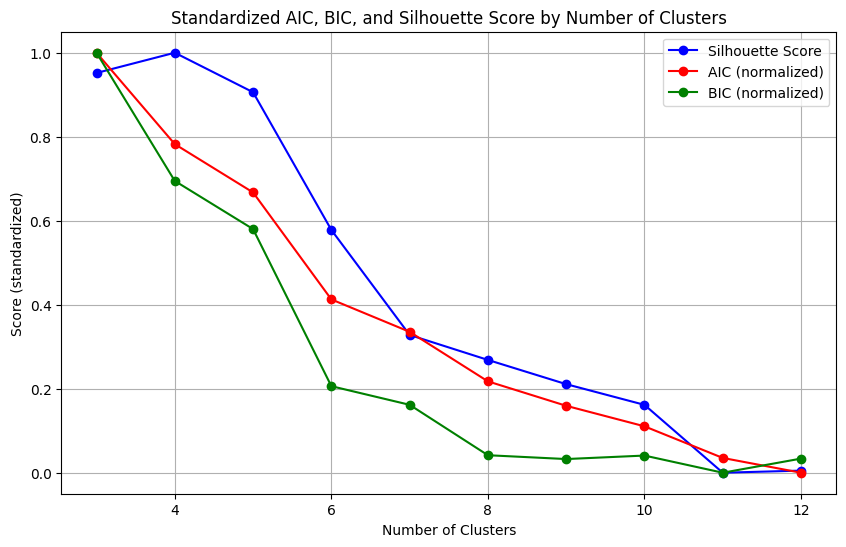

In [21]:
# visualize
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sil_scores, marker='o', label='Silhouette Score', color='blue')
plt.plot(cluster_range, aic_scores, marker='o', label='AIC (normalized)', color='red')
plt.plot(cluster_range, bic_scores, marker='o', label='BIC (normalized)', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Score (standardized)')
plt.title('Standardized AIC, BIC, and Silhouette Score by Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
optimal_clusters = 9
gm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gm.fit(all_principal_components)  

gm_labels = gm.predict(all_principal_components)

gm_df = pd.DataFrame({
    'Id': scaled.index,
    'Predicted': gm_labels
})

In [18]:
gm_df.head()

,Id,Predicted
0,0,3
1,1,1
2,2,3
3,3,6
4,4,4


In [19]:
gm_df.to_csv('submission_gm2.csv', index=False)

# Bayesian Gaussian Mixture

In [ ]:
cluster_range = range(3, 10)

sil_scores = []
aic_scores = []
bic_scores = []

all_principal_components = pca.transform(scaled.iloc[:, 1:])

for n_clusters in cluster_range:
    gm = GaussianMixture(n_components=n_clusters, random_state=42)
    gm_preds = gm.fit_predict(all_principal_components)
    
    sil = silhouette_score(all_principal_components, gm_preds)
    sil_scores.append(sil)
    
    aic = gm.aic(all_principal_components)
    bic = gm.bic(all_principal_components)
    aic_scores.append(aic)
    bic_scores.append(bic)

max_aic, min_aic = max(aic_scores), min(aic_scores)
max_bic, min_bic = max(bic_scores), min(bic_scores)
max_sil, min_sil = max(sil_scores), min(sil_scores)

aic_scores = [(x-min_aic)/(max_aic-min_aic) for x in aic_scores]
bic_scores = [(x-min_bic)/(max_bic-min_bic) for x in bic_scores]
sil_scores = [(x-min_sil)/(max_sil-min_sil) for x in sil_scores]

In [97]:
cluster_range = range(3, 10)

sil_scores = []
aic_scores = []
bic_scores = []

all_principal_components = pca.transform(scaled.iloc[:, 1:])

for n_clusters in cluster_range:
    bgm = BayesianGaussianMixture(n_components=n_clusters, random_state=42)
    bgm_preds = bgm.fit_predict(all_principal_components)
    
    sil = silhouette_score(all_principal_components, bgm_preds)
    sil_scores.append(sil)
    
    log_likelihood = bgm.score(all_principal_components)
    n_samples, n_features = all_principal_components.shape
    n_parameters = n_clusters * (n_features + n_features * (n_features + 1) // 2)
    
    aic = -2 * log_likelihood + 2 * n_parameters
    bic = -2 * log_likelihood + n_parameters * np.log(n_samples)
    
    aic_scores.append(aic)
    bic_scores.append(bic)

max_aic, min_aic = max(aic_scores), min(aic_scores)
max_bic, min_bic = max(bic_scores), min(bic_scores)
max_sil, min_sil = max(sil_scores), min(sil_scores)

aic_scores = [(x-min_aic)/(max_aic-min_aic) for x in aic_scores]
bic_scores = [(x-min_bic)/(max_bic-min_bic) for x in bic_scores]
sil_scores = [(x-min_sil)/(max_sil-min_sil) for x in sil_scores]

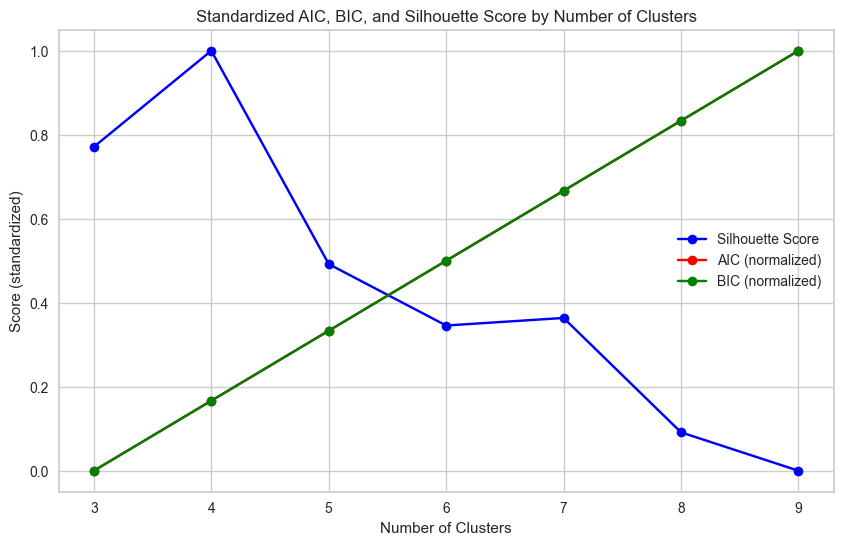

In [101]:
# visualize
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sil_scores, marker='o', label='Silhouette Score', color='blue')
plt.plot(cluster_range, aic_scores, marker='o', label='AIC (normalized)', color='red')
plt.plot(cluster_range, bic_scores, marker='o', label='BIC (normalized)', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Score (standardized)')
plt.title('Standardized AIC, BIC, and Silhouette Score by Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

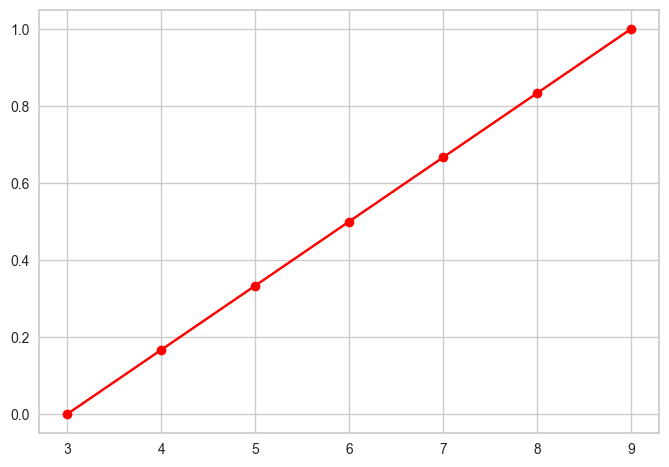

In [107]:
plt.plot(cluster_range, aic_scores, marker='o', label='AIC (normalized)', color='red')

In [112]:
optimal_clusters = 6
bgm = BayesianGaussianMixture(n_components=optimal_clusters, covariance_type = 'full', n_init=3, random_state=42,max_iter=1000)
bgm.fit(all_principal_components)  

bgm_labels = bgm.predict(all_principal_components)

bgm_df = pd.DataFrame({
    'Id': scaled.index,
    'Predicted': labels
})

In [113]:
bgm_df.head()

,Id,Predicted
0,0,6
1,1,1
2,2,6
3,3,5
4,4,2


> notes ini keknya buat BGM masih salah kocak